<a href="https://colab.research.google.com/github/rokmr/Computational-Methods-of-Optimization/blob/main/kNN_using_features_extracted_from_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 k-NN : Use an ImageNet pre-trained ResNet-18 model to extract deep features for the given
images. Evaluate image classification accuracy using k-NN classifier using these features.
Extract the features from the last/second-last fully connected layer.


# Importng Required Library

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets, models

import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# Setting Device and Data 

In [3]:
# Setting device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Setting up file directory
from pathlib import Path
data_dir = Path('/content/drive/Shareddrives/Python Basics/AIP_Assignment/A1/classification_dataset')

In [6]:
data_transforms = transforms.Compose([
                  transforms.Resize((224,224)),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                  ])

In [10]:
image_datasets = {x: datasets.ImageFolder(data_dir / x, data_transforms) for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True) for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes


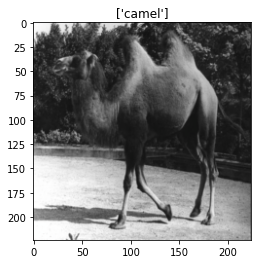

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model for feature extraction

In [12]:
# importing ResNet18 and replacing fc layer with Identiy layer
model_ft = models.resnet18(pretrained=True).to(device)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model_ft.fc = Identity()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
print(model_ft.avgpool)
print(model_ft.fc)

AdaptiveAvgPool2d(output_size=(1, 1))
Identity()


# Feature Extraction

In [14]:
def feature_extractor(model,data_in:torch.utils.data.dataloader.DataLoader):
  '''
  data: train/ test data
  return:
  features array
  features label
  '''
  model = model.to("cpu")               # as most of the operation is done in numpy and list for this section
  extracted_features = []
  with torch.inference_mode():                                                    
    model_ft.eval()
    for batch, (X, y) in  tqdm(enumerate(data_in)):
      # Send data to target device
      X, y = X.to('cpu'), y.to('cpu')
        
      Arr = np.append(model(X)[0].numpy(), y.numpy()[0])
      extracted_features.append(Arr)
  extracted_features = np.array(extracted_features)
  model = model.to(device)              # after computation moving model back to original device
  return torch.from_numpy(extracted_features).type(torch.float32)

In [15]:
# Feature Extraction of train data
train = feature_extractor(model_ft, dataloaders["train"])
X_train = train[:,:512]
y_train = train[:,512]

0it [00:00, ?it/s]

In [16]:
# Feature Extraction of test data
test = feature_extractor(model_ft, dataloaders["test"])
X_test = test[:,:512]
y_test = test[:,512]

0it [00:00, ?it/s]

# KNN Classifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [18]:
def knn_classifier(model,X_train, y_train, X_test, y_test,k:int):
    '''
    Input:
    model : working Model
    X_train, y_train : train data, train label
    X_test, y_test : test data, train label
    k : no. of neighbour

    return:
    test_error : test error on test data
    conf_matrix : confusion Matrix
    acc*100 : accuracy in percentage 
    '''
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train) 
   
    y_pred_test = knn_model.predict(X_test)
    acc = accuracy_score(y_test.numpy(),y_pred_test)
    test_error = 1 - acc
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    return test_error, conf_matrix, acc*100

In [19]:
# Checking knn for different values of k, to find the best suit
test_error_rates = []

for k in range(1,30):
  test_error, _, _ = knn_classifier(model_ft, X_train, y_train, X_test, y_test, k)
  test_error_rates.append(test_error)

Text(0.5, 0, 'K Value')

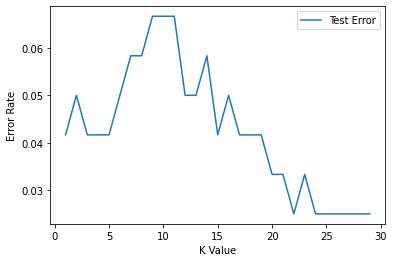

In [20]:
# Plotting error for different values of k
plt.figure()
plt.plot(range(1,30),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value")

In [21]:
# Choosing optimal value of k and evaluation on it 
_, conf_mat, acc_perct = knn_classifier(model_ft, X_train, y_train, X_test, y_test, 4)

print(f"Accuracy percentage : {acc_perct}")
print("----------------------------------")
print("Confusion Matrix")
print(conf_mat)

Accuracy percentage : 95.83333333333334
----------------------------------
Confusion Matrix
[[17  0  0  2  1  0]
 [ 0 20  0  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  1  0 19  0  0]
 [ 0  0  0  1 19  0]
 [ 0  0  0  0  0 20]]
